Source: https://www.kaggle.com/lucasmorin/optiver-realized-volatility-introduction?scriptVersionId=69329513

# Exploration of the train data and stock / day clustering

The idea of this notebook was to perform a basic exploration of the train data. This base exploration of the target lead me to consider the squared error with the base prediciton and observe some correlation between stock and day, then to some basic hierarchical clustering. As our main data doesn't contain much information other than prices, learning and using those high level correlations might be at the core of the competition. Along the way I also find hindsight about the data and the target / error (and a weird outlier). If you find the notebook to be usefull / interesting feel free to upvote, this will keep me motivated to share more hindsights trough the competition.

**Version 2 :** I updated the notebook to better reflect my understanding of the competition.

**Version 3 :** I updated the notebook to add a codependance § as I feel like this is what this competition is all about.

- [Objective of the competition](#Objective)
- [Stock and Time repartition](#Stock_time_repartition)
- [Target Distribution](#Target_Distribution)
- [Optiver Base Function](#Optiver_base_functions)
- [Custom Objective](#RMSPE)
- [Base Prediction Error](#Base_prediction_error)
- [Codependance](#Codependance)
- [Weird Outlier](#Weird_Outlier)
- [Correlation Matrices - Clustering - Target](#Correlation_Matrices_target)
- [Correlation Matrices - Clustering - Error](#Correlation_squared_error)

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px

import matplotlib.pyplot as plt

train = pd.read_csv('../input/optiver-realized-volatility-prediction/train.csv', dtype = {'stock_id': np.int32, 'time_id': np.int32, 'target': np.float64})
train.head()

,stock_id,time_id,target
0,0,5,0.004136
1,0,11,0.001445
2,0,16,0.002168
3,0,31,0.002195
4,0,62,0.001747


In [2]:
book_example = pd.read_parquet('../input/optiver-realized-volatility-prediction/book_train.parquet/stock_id=0')
trade_example =  pd.read_parquet('../input/optiver-realized-volatility-prediction/trade_train.parquet/stock_id=0')
stock_id = '0'
book_example = book_example[book_example['time_id']==5]
book_example.loc[:,'stock_id'] = stock_id
trade_example = trade_example[trade_example['time_id']==5]
trade_example.loc[:,'stock_id'] = stock_id


book_example['wap'] = (book_example['bid_price1'] * book_example['ask_size1'] +
                                book_example['ask_price1'] * book_example['bid_size1']) / (
                                       book_example['bid_size1']+ book_example['ask_size1'])


def log_return(list_stock_prices):
    return np.log(list_stock_prices).diff()

def realized_volatility(series_log_return):
    return np.sqrt(np.sum(series_log_return**2))

book_example.loc[:,'log_return'] = log_return(book_example['wap'])
book_example = book_example[~book_example['log_return'].isnull()]

<a id='Objective'></a>
# Objective of the competition :

We have a bunch of time series of 10 minutes length of differents stocks over different time periods. The goal of this competition is to predict the volatility of the stock over the next ten minutes, not the price. Let's have a look at one of the price time serie.

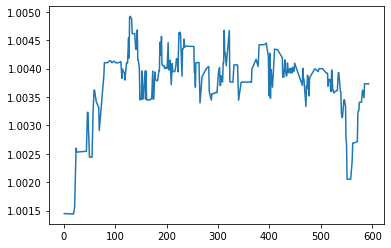

In [3]:
plt.plot(book_example['seconds_in_bucket'],book_example['wap'])

Next the volatility :

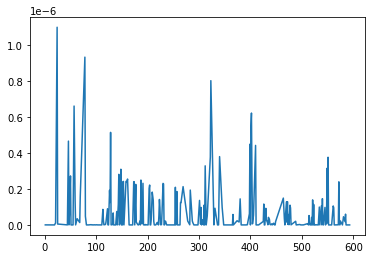

In [4]:
plt.plot(book_example['seconds_in_bucket'],book_example['log_return']**2)

The question is what happen next ?

Text(900, 6e-07, '???')

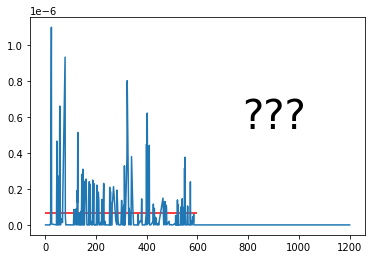

In [5]:
x = np.append(book_example['seconds_in_bucket'].values,1200)
y = np.append((book_example['log_return']**2).values,0)
z = np.mean(book_example['log_return']**2)

plt.hlines(z,xmin=0,xmax=600,color='red')
plt.plot(x,y)
plt.text(900, 0.6*1e-6,'???', ha='center', va='center', size = 40)

<a id='Stock_time_repartition'></a>
# Repartition of Stock x Time

We start with a simple exploration of stock x time repartition to look for any exploitable pattern. 

In [6]:
print(f'Number of unique stocks is {train.stock_id.nunique()}')
print(f'Number of unique time_id is {train.time_id.nunique()}')

Number of unique stocks is 112
Number of unique time_id is 3830


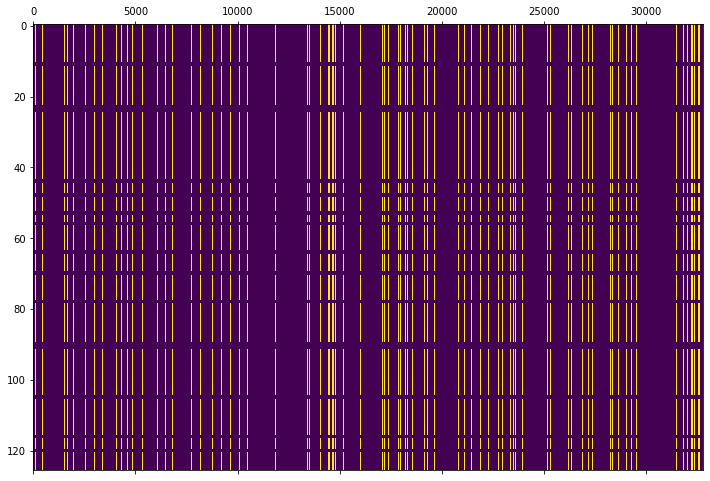

In [7]:
import matplotlib.pyplot as plt
import numpy as np

n_stock = np.max(train.stock_id)
n_time = np.max(train.time_id)

mat_plot = np.zeros((n_stock, n_time))

s_id = train.stock_id.values
t_id = train.time_id.values

for k in range(train.shape[0]):
    i = s_id[k]-1
    j = t_id[k]-1
    mat_plot[i,j] = 1
  
plt.figure(figsize=(12,8))
plt.matshow(mat_plot, fignum=1, aspect='auto')

There doesn't seems to be anything exploitable here. I even think times are shuffled so that it would be difficult to use anything based on those.

<a id='Target_Distribution'></a>
# Target distribution

We observe a somewhat skewed distribution of the target. Given the square in the objective function dealing with those outliers mihgt be one of our main goals.

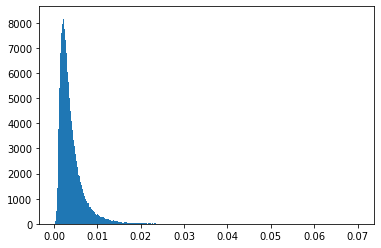

In [8]:
plt.hist(train.target, bins = 1000)
plt.show()

In [9]:
hist = np.histogram(train.target, bins=1000)
idx = np.argmax(hist[0])

print(f'Target mean is {np.mean(train.target)}')
print(f'Target median is {np.median(train.target)}')
print(f'Target mode is {hist[1][idx]}')

Target mean is 0.0038804095369522435
Target median is 0.003048022
Target mode is 0.002001077639


Past seems is used as a benchmark. We might want to try other benchmarks suchs as the median or the mode, the more populous values, not the mean that can be influenced by outliers. (Or may be it might be better to get more influence from outliers, I don't know yet).

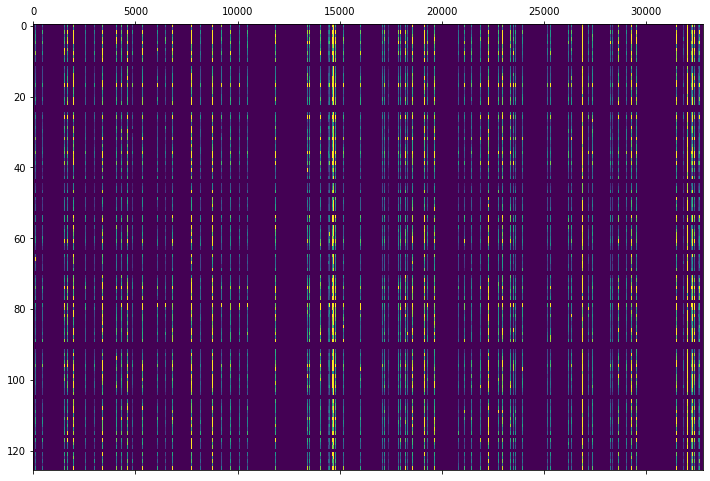

In [10]:
n_stock = np.max(train.stock_id)
n_time = np.max(train.time_id)

mat_plot = np.zeros((n_stock, n_time))

s_id = train.stock_id.values
t_id = train.time_id.values
t = train.target.values

for k in range(train.shape[0]):
    i = s_id[k]-1
    j = t_id[k]-1
    mat_plot[i,j] = t[k]
  
plt.figure(figsize=(12,8))
plt.matshow(mat_plot, fignum=1, aspect='auto', vmax=0.0075)

It's hard not to see time pattern in targets ... are we sure the time are shuffled ?

<a id='Optiver_base_functions'></a>
# Optiver exemple - Base functions

In [11]:
book_example = pd.read_parquet('../input/optiver-realized-volatility-prediction/book_train.parquet/stock_id=0')
trade_example =  pd.read_parquet('../input/optiver-realized-volatility-prediction/trade_train.parquet/stock_id=0')
stock_id = '0'
book_example = book_example[book_example['time_id']==5]
book_example.loc[:,'stock_id'] = stock_id
trade_example = trade_example[trade_example['time_id']==5]
trade_example.loc[:,'stock_id'] = stock_id


book_example['wap'] = (book_example['bid_price1'] * book_example['ask_size1'] +
                                book_example['ask_price1'] * book_example['bid_size1']) / (
                                       book_example['bid_size1']+ book_example['ask_size1'])


def log_return(list_stock_prices):
    return np.log(list_stock_prices).diff()

book_example.loc[:,'log_return'] = log_return(book_example['wap'])
book_example = book_example[~book_example['log_return'].isnull()]


def realized_volatility(series_log_return):
    return np.sqrt(np.sum(series_log_return**2))
realized_vol = realized_volatility(book_example['log_return'])
print(f'Realized volatility for stock_id 0 on time_id 5 is {realized_vol}')

import os
from sklearn.metrics import r2_score
import glob
list_order_book_file_train = glob.glob('/kaggle/input/optiver-realized-volatility-prediction/book_train.parquet/*')

def realized_volatility_per_time_id(file_path, prediction_column_name):
    df_book_data = pd.read_parquet(file_path)
    df_book_data['wap'] =(df_book_data['bid_price1'] * df_book_data['ask_size1']+df_book_data['ask_price1'] * df_book_data['bid_size1'])  / (
                                      df_book_data['bid_size1']+ df_book_data[
                                  'ask_size1'])
    df_book_data['log_return'] = df_book_data.groupby(['time_id'])['wap'].apply(log_return)
    df_book_data = df_book_data[~df_book_data['log_return'].isnull()]
    df_realized_vol_per_stock =  pd.DataFrame(df_book_data.groupby(['time_id'])['log_return'].agg(realized_volatility)).reset_index()
    df_realized_vol_per_stock = df_realized_vol_per_stock.rename(columns = {'log_return':prediction_column_name})
    stock_id = file_path.split('=')[1]
    df_realized_vol_per_stock['row_id'] = df_realized_vol_per_stock['time_id'].apply(lambda x:f'{stock_id}-{x}')
    return df_realized_vol_per_stock[['row_id',prediction_column_name]]

def past_realized_volatility_per_stock(list_file,prediction_column_name):
    df_past_realized = pd.DataFrame()
    for file in list_file:
        df_past_realized = pd.concat([df_past_realized,
                                     realized_volatility_per_time_id(file,prediction_column_name)])
    return df_past_realized
df_past_realized_train = past_realized_volatility_per_stock(list_file=list_order_book_file_train,
                                                           prediction_column_name='pred')

train['row_id'] = train['stock_id'].astype(str) + '-' + train['time_id'].astype(str)
train = train[['row_id','target']]
df_joined = train.merge(df_past_realized_train[['row_id','pred']], on = ['row_id'], how = 'left')

from sklearn.metrics import r2_score
def rmspe(y_true, y_pred):
    return  (np.sqrt(np.mean(np.square((y_true - y_pred) / y_true))))

R2 = round(r2_score(y_true = df_joined['target'], y_pred = df_joined['pred']),3)
RMSPE = round(rmspe(y_true = df_joined['target'], y_pred = df_joined['pred']),3)
print(f'Performance of the naive prediction: R2 score: {R2}, RMSPE: {RMSPE}')

Realized volatility for stock_id 0 on time_id 5 is 0.004499364172786558
Performance of the naive prediction: R2 score: 0.628, RMSPE: 0.341


I don't know why id are merged. More practical to demerge them :

In [12]:
df_joined['se'] = np.square((df_joined['target'] - df_joined['pred']) / df_joined['target'])
df_joined['stock_id'] = df_joined['row_id'].str.partition('-')[0].astype('int')
df_joined['time_id'] = df_joined['row_id'].str.partition('-')[2].astype('int')

<a id='RMSPE'></a>
# Custom objective - RMPSE

It's important to not we are not optimising the an usual regression loss. We need to optimise the RMPSE. That is the usual RMSE corrceted by the target to make it a relative error:

$$ \sqrt{\frac{1}{n}\sum^{n}_{i=1}((y_i-\hat{y_i})/y_i)^2}$$

As it happen, for simple models this is equivalent to weighting the RMSE error by : 

$$ \frac{1}{{y^2}_i} $$

For a complete discussion see here : 
https://www.kaggle.com/c/optiver-realized-volatility-prediction/discussion/250324

For a simple exemple (a linear regression) getting a good score using this basic idea see here :
https://www.kaggle.com/lucasmorin/realised-vol-weighted-regression-baseline

<a id='Base_prediction_error'></a>
# Base prediction - error

Here we study the base prediction error to get some hindsigt on the data.

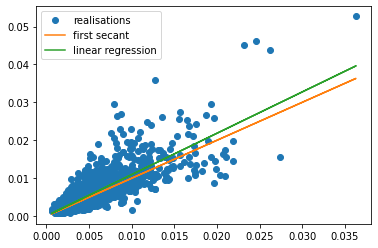

In [13]:
test_df = df_joined[df_joined.stock_id == 0]

plt.plot(test_df.target,test_df.pred, 'o', label='realisations')

m, b = np.polyfit(test_df.target,test_df.pred, 1)

plt.plot(test_df.target, test_df.target, label='first secant')
plt.plot(test_df.target, m*test_df.target+b, label='linear regression')
plt.legend()

A simple linear regression by stock might be a good first step into modelling. 

We then look at the repartition of errors :

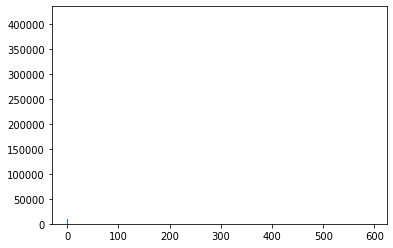

In [14]:
plt.hist(df_joined['se'], bins = 1000)
plt.show()

My favorite graph so far. This is not a bug. You can see the data around 0. This mean we have high contributor to the error. Let's try with a log.

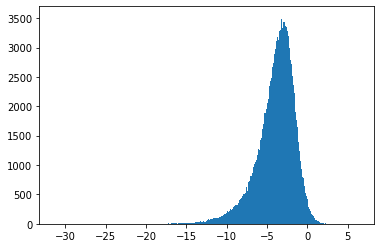

In [15]:
plt.hist(np.log(df_joined['se']), bins = 1000)
plt.show()

Seems better, right ?

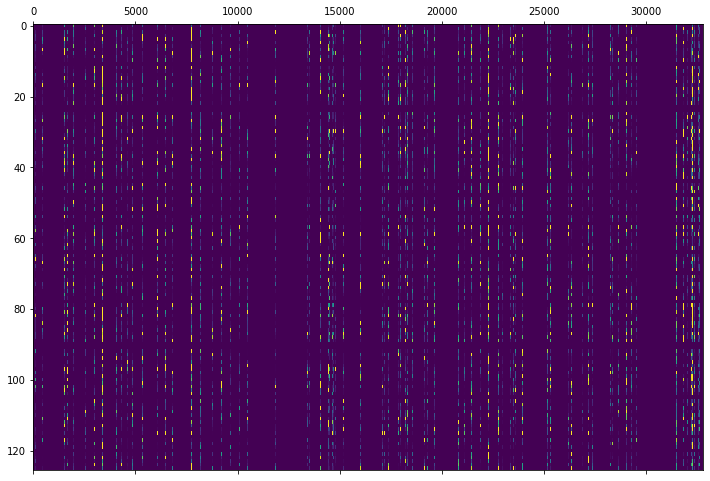

In [16]:
##### n_stock = np.max(df_joined.stock_id)
n_time = np.max(df_joined.time_id)

mat_plot = np.zeros((n_stock, n_time))

s_id = df_joined.stock_id.values
t_id = df_joined.time_id.values
t = df_joined['se'].values

for k in range(train.shape[0]):
    i = s_id[k]-1
    j = t_id[k]-1
    mat_plot[i,j] = t[k]
  
plt.figure(figsize=(12,8))
plt.matshow(mat_plot, fignum=1, aspect='auto',vmax=10*np.median(df_joined['se']))

Errors seems correlated trough stocks. We might have periods with high variations of volatility trough the stock market. Again we can't say much about correlation trough time.

<a id='Codependance'></a>
# Codependance

There is a lot of dependance going on. This might be what this competition is all about. Dependence between two stock targets: 

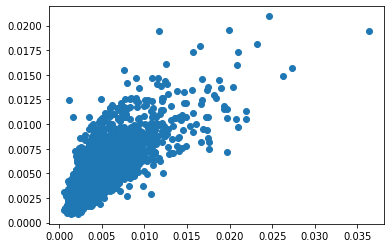

In [17]:
stock_0 = df_joined[df_joined.stock_id == 0]
stock_1 = df_joined[df_joined.stock_id == 1]

plt.scatter(stock_0.target,stock_1.target)

In a quantile-quantile approach:

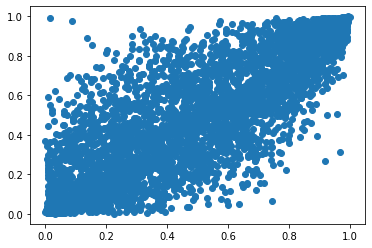

In [18]:
from sklearn.preprocessing import quantile_transform
qt_target_0 = quantile_transform(stock_0.target.values.reshape(-1, 1), n_quantiles=100)
qt_target_1 = quantile_transform(stock_1.target.values.reshape(-1, 1), n_quantiles=100)

plt.scatter(qt_target_0,qt_target_1)

Quantile dependance between realized volatility and prediction :

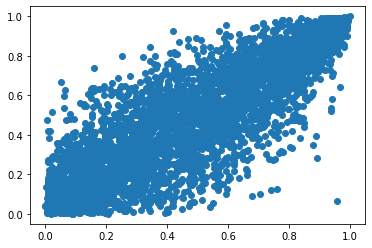

In [19]:
stock_0 = df_joined[df_joined.stock_id == 0]

from sklearn.preprocessing import quantile_transform
qt_target_0 = quantile_transform(stock_0.target.values.reshape(-1, 1), n_quantiles=100)
qt_pred_0 = quantile_transform(stock_0.pred.values.reshape(-1, 1), n_quantiles=100)

plt.scatter(qt_target_0,qt_pred_0)

Copulas anyone ?

<a id='Weird_Outlier'></a>
# Weird Outlier - Stock 31

Looking further into error we notice that a big contributor is stock 31. We might investigate outliers with higher contribution to the error.

In [20]:
df_joined['se'].nlargest(n=10)

110278    594.505592
110479    424.975236
108254    319.099108
107743    196.783787
107548    134.899806
110684    110.685362
108638    101.599540
107806     96.116622
109073     86.652630
107345     71.168004
Name: se, dtype: float64

In [21]:
df_joined.iloc[df_joined['se'].nlargest(n=10).index,]

,row_id,target,pred,se,stock_id,time_id
110278,31-25504,0.000139,0.003528,594.505592,31,25504
110479,31-27174,0.000123,0.002662,424.975236,31,27174
108254,31-8534,0.000105,0.001986,319.099108,31,8534
107743,31-4142,0.000137,0.002061,196.783787,31,4142
107548,31-2479,0.000109,0.001375,134.899806,31,2479
110684,31-29228,0.000206,0.002373,110.685362,31,29228
108638,31-11844,0.000175,0.001940,101.599540,31,11844
107806,31-4649,0.000225,0.002433,96.116622,31,4649
109073,31-15194,0.000237,0.002440,86.652630,31,15194
107345,31-1020,0.000301,0.002843,71.168004,31,1020


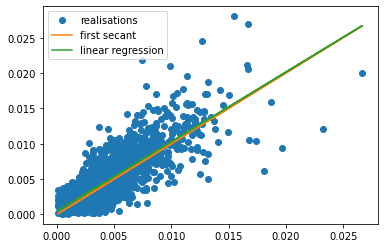

In [22]:
test_df = df_joined[df_joined.stock_id == 31]

plt.plot(test_df.target,test_df.pred, 'o', label='realisations')

m, b = np.polyfit(test_df.target,test_df.pred, 1)

plt.plot(test_df.target, test_df.target, label='first secant')
plt.plot(test_df.target, m*test_df.target+b, label='linear regression')
plt.legend()

It's not evident what is the problem here as the linear correlation seems to hold. However this might be due to the definition of  the objective. The error being relative means that biggest contributions my lie near the origin.

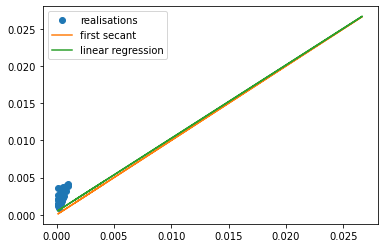

In [23]:
test_df = df_joined[df_joined.stock_id == 31]

test_df2 = test_df.loc[test_df['se'].nlargest(n=50).index,]

plt.plot(test_df2.target,test_df2.pred, 'o', label='realisations')

m, b = np.polyfit(test_df.target,test_df.pred, 1)

plt.plot(test_df.target, test_df.target, label='first secant')
plt.plot(test_df.target, m*test_df.target+b, label='linear regression')
plt.legend()

<a id='Correlation_Matrices_target'></a>
# Correlation Matrices - Clustering - target

It's still unclear to me if stocks can be considered independtly or not. So I tried to look a bit into it, first with correlation, then with hierarchical clustering.

<a id='Stock_correlation_target'></a>
## Stock correlation - Clustering

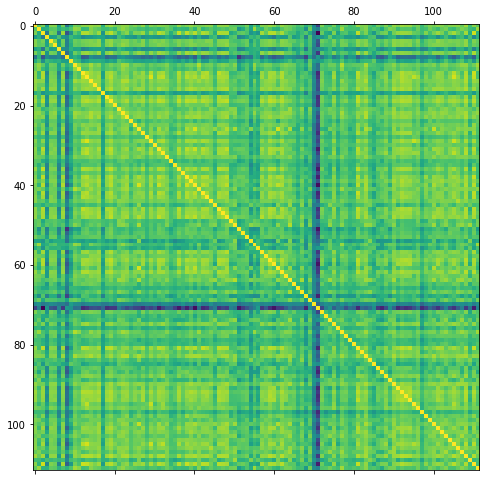

In [24]:
dfp = df_joined.pivot('time_id','stock_id')
mat_corr = dfp.target.corr()

plt.figure(figsize=(8,8))
plt.matshow(mat_corr, fignum=1, aspect='auto')

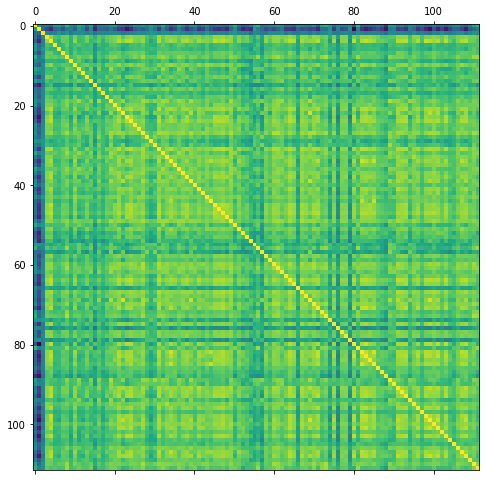

In [25]:
import scipy
import scipy.cluster.hierarchy as sch

X = mat_corr
d = sch.distance.pdist(X)   # vector of ('55' choose 2) pairwise distances
L = sch.linkage(d, method='complete')
ind = sch.fcluster(L, 0.5*d.max(), 'distance')
columns = [dfp.target.columns.tolist()[i] for i in list((np.argsort(ind)))]

plt.figure(figsize=(8,8))
plt.matshow(dfp.target[columns].corr(), fignum=1, aspect='auto')

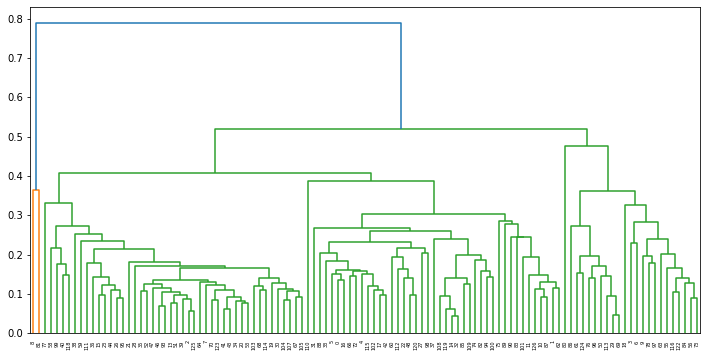

In [26]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform

plt.figure(figsize=(12,6))
dissimilarity = 1 - abs(mat_corr)
Z = linkage(squareform(dissimilarity), 'complete')

dendrogram(Z, labels=dfp.target.columns, orientation='top', 
           leaf_rotation=90);

There appears to be 2 outliers, other than that the conclusion seems to be that there is enough correlations so that it should be taken into account. 

<a id='Time_correlation_target'></a>
## Time correlation - Clustering

Another approach of clustering might be trough time clustering. That is burst, of correlation might appears on a given date, due to a significant external event. 

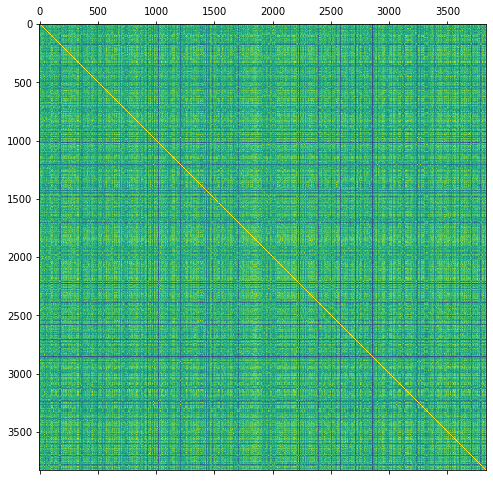

In [27]:
dfp = df_joined.pivot('stock_id','time_id')
mat_corr = dfp.target.corr()

plt.figure(figsize=(8,8))
plt.matshow(mat_corr, fignum=1, aspect='auto')

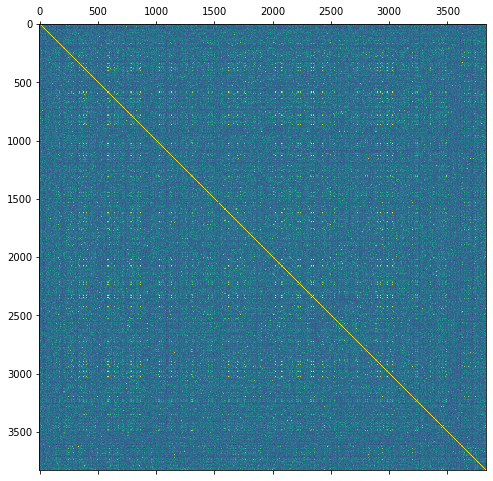

In [28]:
X = mat_corr
d = sch.distance.pdist(X)
L = sch.linkage(d, method='complete')
ind = sch.fcluster(L, 0.5*d.max(), 'distance')
columns = [dfp.se.columns.tolist()[i] for i in list((np.argsort(ind)))]

plt.figure(figsize=(8,8))
plt.matshow(dfp.se[columns].corr(), fignum=1, aspect='auto')

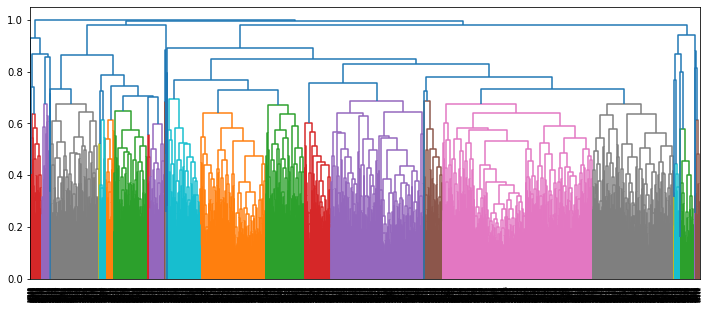

In [29]:
plt.figure(figsize=(12,5))
dissimilarity = 1 - abs(mat_corr)
Z = linkage(squareform(dissimilarity), 'complete')

dendrogram(Z, labels=dfp.target.columns, orientation='top', 
           leaf_rotation=90);

Correlation is less clear. Still, some lowly correlated clusters seems to appear.

<a id='Correlation_squared_error'></a>
# Correlation - Clustering - squared error

The same can be done with base error prediction. This might help understand where the difficulty of the competition lie.

<a id='Stock_correlation_se'></a>
## Stock correlation - Clustering

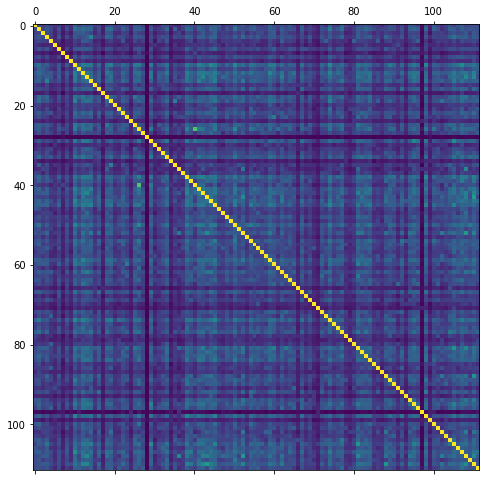

In [30]:
dfp = df_joined.pivot('time_id','stock_id')
mat_corr = dfp.se.corr()

plt.figure(figsize=(8,8))
plt.matshow(mat_corr, fignum=1, aspect='auto')

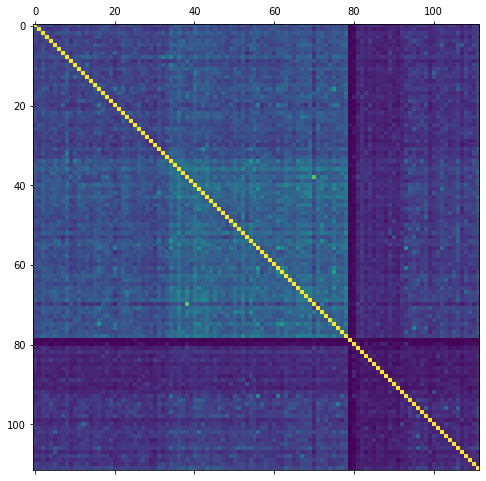

In [31]:
X = mat_corr
d = sch.distance.pdist(X)   # vector of ('55' choose 2) pairwise distances
L = sch.linkage(d, method='complete')
ind = sch.fcluster(L, 0.5*d.max(), 'distance')
columns = [dfp.se.columns.tolist()[i] for i in list((np.argsort(ind)))]

plt.figure(figsize=(8,8))
plt.matshow(dfp.se[columns].corr(), fignum=1, aspect='auto')

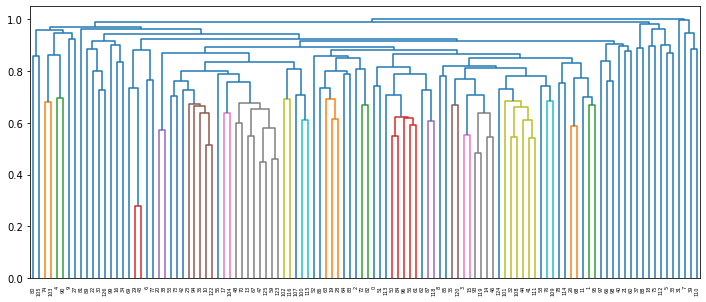

In [32]:
plt.figure(figsize=(12,5))
dissimilarity = 1 - abs(mat_corr)
Z = linkage(squareform(dissimilarity), 'complete')

dendrogram(Z, labels=dfp.target.columns, orientation='top', 
           leaf_rotation=90);

From the correlation matrix there seems to be 2/3 clusters that appear on the dendogram. It is ot clear how to exploit that.

<a id='Time_correlation_se'></a>
## Time correlation - Clustering

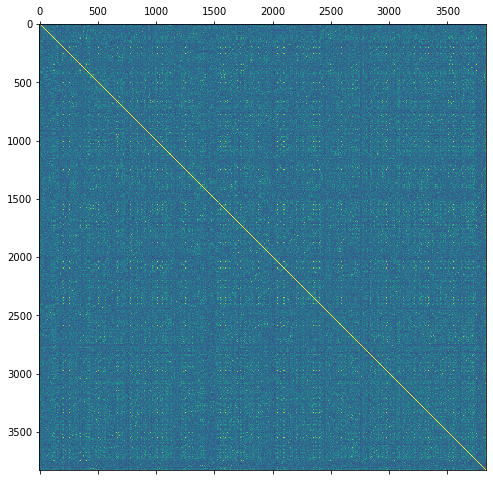

In [33]:
dfp = df_joined.pivot('stock_id','time_id')
mat_corr = dfp.se.corr()

plt.figure(figsize=(8,8))
plt.matshow(mat_corr, fignum=1, aspect='auto')

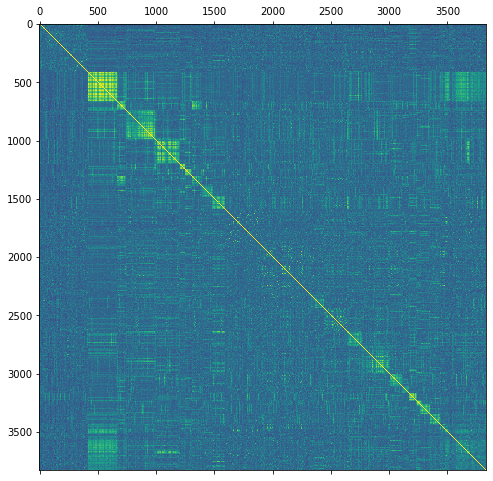

In [34]:
X = mat_corr
d = sch.distance.pdist(X)
L = sch.linkage(d, method='complete')
ind = sch.fcluster(L, 0.5*d.max(), 'distance')
columns = [dfp.se.columns.tolist()[i] for i in list((np.argsort(ind)))]

plt.figure(figsize=(8,8))
plt.matshow(dfp.se[columns].corr(), fignum=1, aspect='auto')

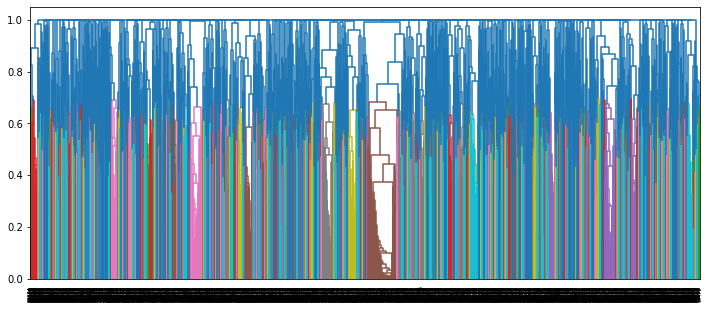

In [35]:
plt.figure(figsize=(12,5))
dissimilarity = 1 - abs(mat_corr)
Z = linkage(squareform(dissimilarity), 'complete')

dendrogram(Z, labels=dfp.target.columns, orientation='top', 
           leaf_rotation=90);

The time clustering appears more interesting here than the previous one as some clusters seems to appears more distinctively in the correlation matrix. However this might be due to sample that were chosen closely, not necessarily to something that can be exploited in the future.